In [ ]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_wine
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

---
### Классификация вина
---

Рассмотрим датасет для классификации вина на три класса по 13 вещественным признакам. Датасет состоит из 178 объектов.

In [ ]:
print(load_wine()['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

Загрузим сами данные

In [ ]:
X, y = load_wine(return_X_y=True)
X.shape, y.shape

((178, 13), (178,))

**1.** Используя одну из стратегий кросс-валидации подберем оптимальные параметры обучения решающего дерева &mdash; `max_depth` (от 1 до 14) и `min_samples_split`, а также оптимальный критерий (достаточно рассмотреть критерий Джини и энтропийный). В качестве метрик возьмем Accuracy и F1 с микро и макро усреднением.

Будем использовать k-fold cross-validation с k=5 и полный перебор по сетке. Зададим функцию получения лучших параметров дерева для конкретной метрики.

In [ ]:
params_grid = {
    'max_depth': np.arange(1, 15),
    'min_samples_split': np.arange(2, 11),
    'criterion': ['gini', 'entropy']
}

def get_best_params(scoring, model, X=X, y=y, params=params_grid, cv=5, **kwargs):
    '''
    Функция поиска лучших параметров модели для конкретной метрики.

    Параметры.
    1) scoring - метрика для оценки качества модели
    2) model - целевая модель
    3) X - матрица признаков
    4) y - вектор целевой переменной
    5) params - словарь с параметрами для перебора
    6) cv - количество фолдов для k-fold cross-validation
    '''

    grid = GridSearchCV(model, params, cv=cv, scoring=scoring, **kwargs)
    grid.fit(X, y)
    return grid.best_params_, grid.best_score_

Получим лучшие параметры.

In [ ]:
scorings = ['accuracy', 'f1_micro', 'f1_macro']
cv_result = {}

for scoring in scorings:
    cv_result[scoring] = get_best_params(scoring, DecisionTreeClassifier())

In [ ]:
for scoring in scorings:
    print(f'Best params for {scoring}: {cv_result[scoring][0]}')
    print(f'Best score for {scoring} : {cv_result[scoring][1]:.5}\n')

Best params for accuracy: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 9}
Best score for accuracy : 0.92143

Best params for f1_micro: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 6}
Best score for f1_micro : 0.92143

Best params for f1_macro: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 8}
Best score for f1_macro : 0.92572



Построим графики зависимости метрик от максимальной глубины дерева для каждого критерия на train и на test.

In [ ]:
# примерно среднее значение между разными метриками
fixed_min_samples_split = 6

In [ ]:
def get_score(scoring, model, X=X, y=y):
    '''
    Функция для оценки качества модели с заданными параметрами.

    Параметры.
    1) scoring - метрика для оценки качества модели
    2) model - целевая модель
    3) params - словарь с параметрами для перебора
    4) X - матрица признаков
    5) y - вектор целевой переменной
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    model.fit(X_train, y_train)

    scorer = metrics.get_scorer(scoring)
    return scorer(model, X_train, y_train), scorer(model, X_test, y_test)

Получим значения для графиков и визуализируем их.

In [ ]:
results = {}
for scoring in scorings:
    for max_depth in params_grid['max_depth']:
        for criterion in params_grid['criterion']:
            # фиксируем параметры
            params = {
                'max_depth': max_depth,
                'min_samples_split': fixed_min_samples_split,
                'criterion': criterion
            }

            # считаем метрику
            model = DecisionTreeClassifier(**params)
            score = get_score(scoring, model)
            results[(scoring, max_depth, fixed_min_samples_split, criterion)] = score

In [ ]:
def plot_results(results, scoring, params_grid=params_grid):
    '''
    Функция для построения графика зависимости метрики от параметров модели.

    Параметры.
    1) results - словарь с результатами перебора параметров
    2) scoring - метрика для оценки качества модели
    3) params_grid - словарь с параметрами для перебора
    '''

    plt.title(f'Зависимость {scoring} от max_depth')
    plt.xlabel('max_depth')
    plt.ylabel('score')

    colors = {
        'gini' : 'tab:blue',
        'entropy' : 'tab:orange',
    }

    for criterion in params_grid['criterion']:
        scores = np.array([
            results[(scoring, max_depth, fixed_min_samples_split, criterion)]
            for max_depth in params_grid['max_depth']
        ])

        color = colors[criterion]
        plt.plot(params_grid['max_depth'], scores[:,0], label=criterion + ' train', color=color, lw=3, linestyle='--')
        plt.plot(params_grid['max_depth'], scores[:,1], label=criterion + ' test' , color=color, lw=3)

    plt.legend()

Посмотрим на графики.

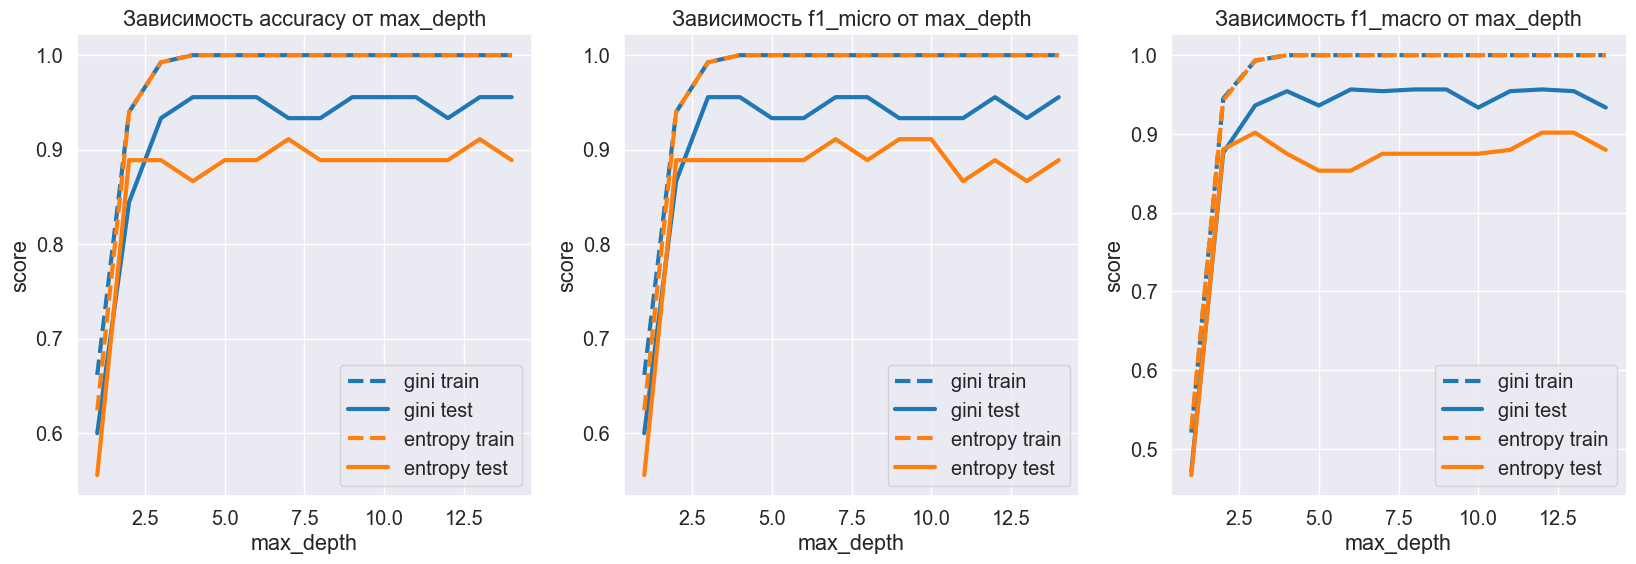

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plot_results(results, 'accuracy')
plt.subplot(1, 3, 2)
plot_results(results, 'f1_micro')
plt.subplot(1, 3, 3)
plot_results(results, 'f1_macro')
plt.show()

1) Train-графики по всем метрикам выглядят одинаково: быстро доходят до единицы, при этом в зависимости от критерия почти не отличаются. То есть исключительно с train стороны алгоритма мы не можем понять, какой же критерий лучше, благо для валидации у нас есть специально отложенные test данные.

2) Как показывают test-графики, во всех метриках оптимальные параметры gini дают результаты лучше, чем оптимальные параметры для entropy.

3) Заметим, что это не совпадает с результатами, которые до этого подобрал GridSearchCV. Это обьясняется тем, что наше случайное разбиения на train и test даёт результаты отличные от того, что получается при разбиении на фолды. Кроме того, мы зафиксировали параметр min_samples_split, а в GridSearchCV он варьировался.

**2.** Подберем коэффициент регуляризации для логистической регрессии и построим аналогичные графики

Сразу обернём создание логистической регрессии в пайплайн, чтобы не забывать использовать стандартизацию признаков при использовании регуляризации.

In [ ]:
def get_logreg_pipeline(**kwargs):
    '''
    Функция для создания пайплайна с логистической регрессией.

    Параметры.
    1) **kwargs - параметры для логистической регрессии
    '''

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(**kwargs))
    ])

    return pipeline

In [ ]:
params_grid_logreg = {'logreg__C': np.logspace(-3, 2, 100)}

cv_result_logreg = {}
for scoring in scorings:
    cv_result_logreg[scoring] = get_best_params(
        scoring,
        get_logreg_pipeline(verbose=0, max_iter=100),
        params=params_grid_logreg
    )

In [ ]:
for scoring in scorings:
    print(f'Best params for {scoring}: {cv_result_logreg[scoring][0]}')
    print(f'Best score  for {scoring}: {cv_result_logreg[scoring][1]:.5}\n')

Best params for accuracy: {'logreg__C': 0.4750810162102798}
Best score  for accuracy: 0.98889

Best params for f1_micro: {'logreg__C': 0.4750810162102798}
Best score  for f1_micro: 0.98889

Best params for f1_macro: {'logreg__C': 0.4750810162102798}
Best score  for f1_macro: 0.98871



Видим, что для логрегрессии коэфициент регуляризации не зависит от метрики и всегда равен ~3.05. При этом она справляется стабильно лучше решающего дерева.

Построим графики.

In [ ]:
results_logreg = {}
for scoring in scorings:
    for C in params_grid_logreg['logreg__C']:
        # фиксируем параметры
        params = {
            'C': C
        }

        # считаем метрику
        model = get_logreg_pipeline(**params)
        score = get_score(scoring, model)
        results_logreg[(scoring, C)] = score

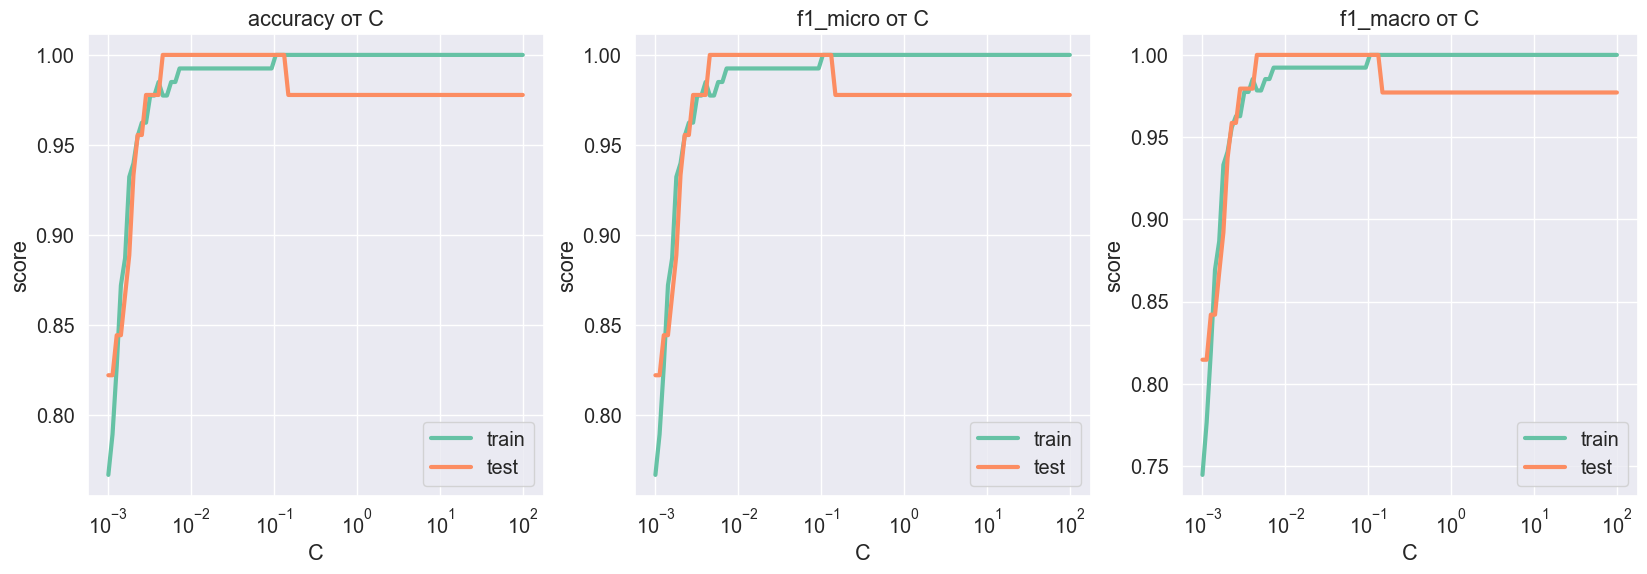

In [ ]:
plt.figure(figsize=(20, 6))

for i, scoring in enumerate(scorings):
    plt.subplot(1, 3, i + 1)
    plt.title(f'{scoring} от C')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('score')

    scores = np.array([results_logreg[(scoring, C)] for C in params_grid_logreg['logreg__C']])
    plt.plot(params_grid_logreg['logreg__C'], scores[:,0], label='train', lw=3)
    plt.plot(params_grid_logreg['logreg__C'], scores[:,1], label='test',  lw=3)

    plt.legend()

plt.show()

Что интересно, даже при слишком большой регуляризации (слева) модель продолжает неплохо обучаться и выдавать адекватные результаты. При этом график по train выглядит как растущая функция, хотя на деле после $10^{-1}$ качество на тесте начинает падать.

**3.** Предположим, что мы не различаем классы 1 и 2. Объединим эти два класса и посмотрим на полученное соотношение классов.

In [ ]:
y[y == 2] = 1
np.unique(y, return_counts=True)

(array([0, 1]), array([ 59, 119]))

Класса 1 стало в два раза больше, чем класса 0.

Подберем параметры с помощью кросс-валидации для лучшего типа модели (логистическая регрессия, решающее дерево). В рамках кросс-валидации посчитаем также метрики Precision и Recall

In [ ]:
params_grid_logreg = {'logreg__C': np.logspace(-3, 2, 100)}

grid = GridSearchCV(
    get_logreg_pipeline(verbose=0, max_iter=100),
    params_grid_logreg,
    scoring=['accuracy', 'precision', 'recall', 'f1_macro'],
    refit='accuracy',
)
grid.fit(X, y);

In [ ]:
print(f'Best params: {grid.best_params_}')
print(f'Best score : {grid.best_score_:.5}')
print(f'Recall     : {grid.cv_results_["mean_test_recall"][grid.best_index_]:.5}')
print(f'Precision  : {grid.cv_results_["mean_test_precision"][grid.best_index_]:.5}')

Best params: {'logreg__C': 6.13590727341317}
Best score : 0.99444
Recall     : 0.99167
Precision  : 1.0


Регуляризация стала чуть сильнее, видимо, чтобы модель не пыталась переобучиться под предсказание класса 1. Скор при этом совсем не уменьшился, даже слегка вырос &mdash; модель подстроилась под новое соотношение классов.

Построим графики ROC и PR кривых для модели с подобранными гиперпараметрами.

In [ ]:
def plot_roc_pr_curves(y_true, y_pred_proba):
    '''
    Функция для построения ROC-кривой.

    Параметры.
    1) y_true - вектор истинных значений целевой переменной
    2) y_pred_proba - вектор предсказанных значений целевой переменной
    '''

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    plt.figure(figsize=(20, 6))
    plt.suptitle('Результаты для логистической регрессии')

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, lw=3)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, lw=3)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-curve')

    plt.show()

Посмотрим на графики.

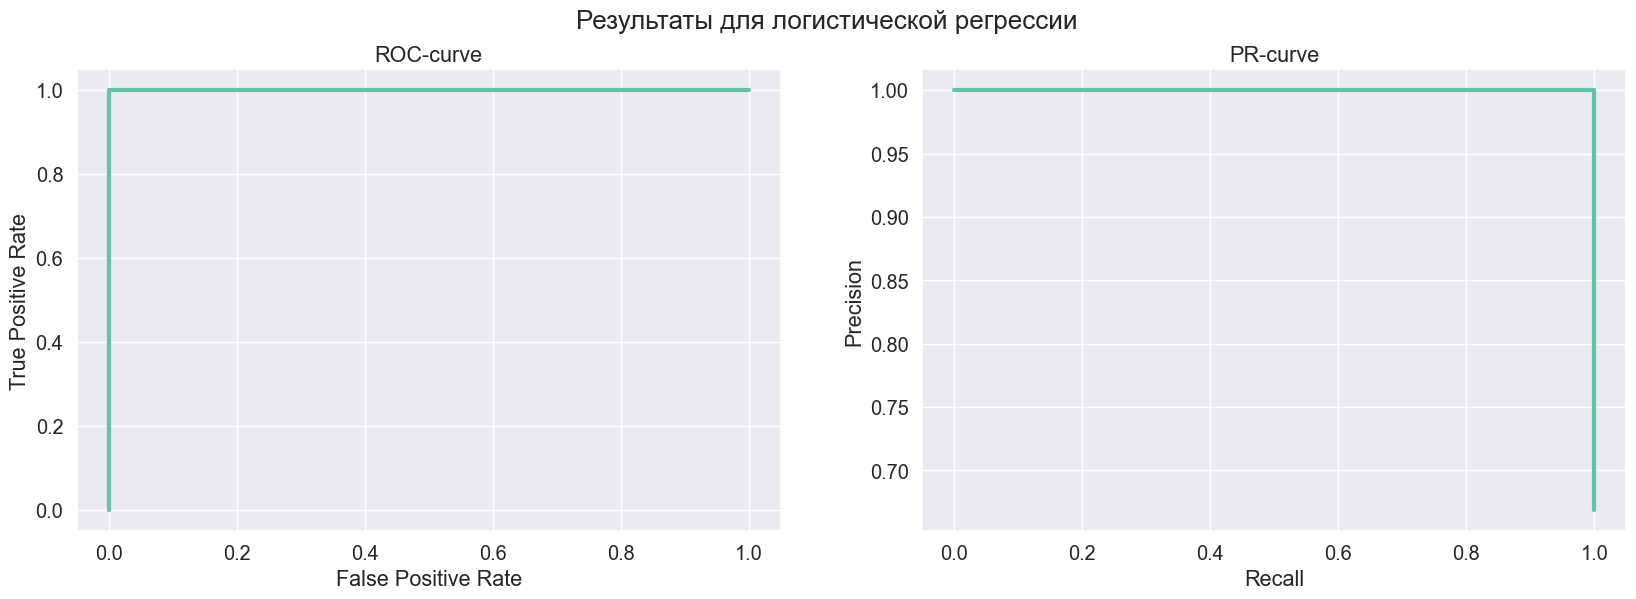

In [ ]:
plot_roc_pr_curves(y, grid.predict_proba(X)[:, 1])

---
### Подходы валидации
---

Рассмотрим модель с наилучшими гиперпараметрами из предыдущей задачи для бинарной классификации. Исследуем свойства различных подходов валидации. В качестве метрики используйте F1-метрику.

Выполним не менее 100 следующих итераций.
1. Перемешаем исходные данные.
2. Выполним подход с однократным разбиением:
    * разделим перемешанные даннные на обучающую и валидационную выборку,
    * обучим модель на обучающей выборке,
    * посчитаем качество модели на валидационной выборке и сохраним это значение.
3. Выполним KFold-валидацию:
    * применим KFold к перемешанным даннным, выполняя разбиение на 5 фолдов,
    * посчитаем среднее и дисперсию качества моделей по фолдам и сохраним эти значения.
4. Аналогично применим ShuffleSplit-валидацию, выполнив 5 ее итераций.
5. Повторим пункты 2-4 для стратифицированных разбиений.

Загрузим ещё раз данные.

In [ ]:
X, y = load_wine(return_X_y=True)
y[y == 2] = 1

Настроим окружение для экспериментов.

In [ ]:
scorer = metrics.get_scorer('f1')

# лучшие параметры для f1_macro
model_params = {
    'C': 0.298
}
model = get_logreg_pipeline(**model_params)

Определим вспомогательные функции.

In [ ]:
def cross_validation_experiment(
    cv_methods,
    n_experiments=100,
    model=model, X=X, y=y):
    '''
    Функция для проведения экспериментов по оценке модели различными методами.

    Параметры.
    1) cv_methods - словарь с обьектами для генерации фолдов
    2) n_experiments - количество экспериментов
    3) model - целевая модель
    4) X - матрица признаков
    5) y - вектор целевой переменной
    '''

    results = {}
    for key in cv_methods.keys():
        results[key] = []

    for _ in range(n_experiments):
        # перемешиваем данные
        shuffle_permutation = np.random.permutation(X.shape[0])
        X = X[shuffle_permutation]
        y = y[shuffle_permutation]

        # для каждого метода кросс-валидации
        for name, cv_method in cv_methods.items():
            # считаем метрику и её статистики
            scores = cross_val_score(model, X, y, cv=cv_method, scoring=scorer)
            mean = np.mean(scores)
            var = np.var(scores)

            # сохраняем результаты
            results[name].append([mean, var])

    return results

Проведём эксперименты.

In [ ]:
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

Не-стратифицированные методы.

In [ ]:
n_experiments = 200
n_splits = 5

methods = {
    'train_test': ShuffleSplit(n_splits=1, test_size=1/n_splits),
    'kfold': KFold(n_splits=n_splits),
    'shuffle_split': ShuffleSplit(n_splits=n_splits, test_size=1/n_splits),
}

np.random.seed(42)
results = cross_validation_experiment(methods, n_experiments=n_experiments)

И стратифицированные.

In [ ]:
n_experiments = 200
n_splits = 5

methods = {
    'strat_train_test': StratifiedShuffleSplit(n_splits=1, test_size=1/n_splits),
    'strat_kfold': StratifiedKFold(n_splits=n_splits),
    'strat_shuffle_split': StratifiedShuffleSplit(n_splits=n_splits, test_size=1/n_splits),
}

np.random.seed(42)
strat_results = cross_validation_experiment(methods, n_experiments=n_experiments)

Объединим все результаты в один словарь и конвертируем в numpy.array для удобной работы

In [ ]:
results.update(strat_results)
methods = sorted(list(results.keys()), key=lambda x: x.split('_')[-1])

for method in methods:
    results[method] = np.array(results[method])

По всем итерациям посчитаем
* выборочную дисперсию среднего качества моделей для каждого из трех подходов, тем самым оценив разброс значений метрик в каждом подходе;
* построим kde-график среднего качества моделей;
* для подходов KFold и ShuffleSplit посчитаем выборочное среднее дисперсии качества моделей по фолдам, тем самым оценив разброс метрик между фолдами/итерациями.

Распишем по пунктам.

* выборочную дисперсию среднего качества моделей для каждого из трех подходов, тем самым оценив разброс значений метрик в каждом подходе;

Считаем средние значения дисперсий и точности.

In [ ]:
means = np.array([np.mean(results[method][:,0]) for method in methods])
vars = np.array([np.var(results[method][:,0]) for method in methods])

pd.DataFrame({
    'method': methods,
    'mean': means,
    'var': vars
})

,method,mean,var
0,kfold,0.987539,0.000017
1,strat_kfold,0.987627,0.000013
2,shuffle_split,0.986333,0.000057
3,strat_shuffle_split,0.987723,0.000053
4,train_test,0.988576,0.000266
5,strat_train_test,0.988323,0.000204


Наибольший разброс оказался у train_test метода, что логично &mdash; по факту, он провел в пять раз меньше итераций оценки качества, чем остальные методы. У kfold и shuffle_split разброс примерно одинаковый. Стратификация незначительно помогла снизить разброс обоим методам CV. Посмотрим, что покажет kdeplot.

* построим kde-график среднего качества моделей;

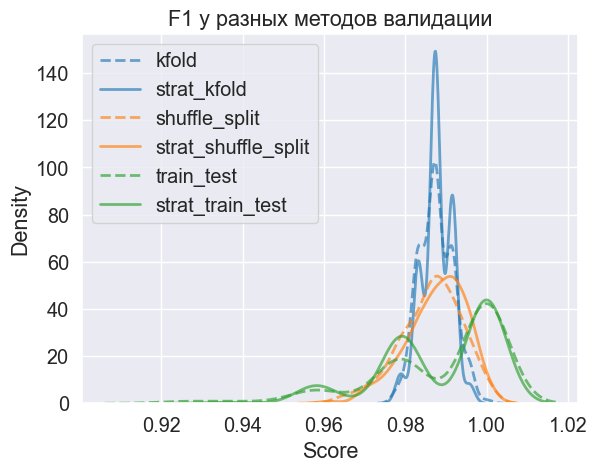

In [ ]:
colors = {
    'train_test': 'tab:green',
    'kfold': 'tab:blue',
    'shuffle_split': 'tab:orange',
}

for method in methods:
    if method.startswith('strat'):
        color = colors[method[len('strat_'):]]
        linestyle='-'
    else:
        color = colors[method]
        linestyle='--'

    sns.kdeplot(
        results[method][:,0], label=method,
        color=color, linestyle=linestyle, lw=2, alpha=0.65
    )

plt.title('F1 у разных методов валидации')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

Наглядно видим, что средняя точность модели у всех методов совпадает, при это у train_test метода разброс значений метрик больше, чем у остальных, а kfold выдает самый стабильный результат. Стратификация слегка увеличила стабильность kfold, остальные методы от неё практически не выиграли.

* для подходов KFold и ShuffleSplit посчитаем выборочное среднее дисперсии качества моделей по фолдам, тем самым оценив разброс метрик между фолдами/итерациями.

In [ ]:
fold_vars = np.array([np.mean(results[method][:,1]) for method in methods])

pd.DataFrame({
    'method': [method for method in methods],
    'var': fold_vars
})

,method,var
0,kfold,0.000211
1,strat_kfold,0.000203
2,shuffle_split,0.000187
3,strat_shuffle_split,0.000173
4,train_test,0.000000
5,strat_train_test,0.000000


Средняя дисперсия метрики по фолдам у методов практически совпадает, однако у shuffle_split она все же чуть меньше.

train_test-метод: самый простой в использовании, требует меньше всего обучений модели, но при этом даёт наименьшую стабильность в средней оценки качества модели. Хорошо подходит для первой оценки качества или дизайна эксперимента, но не для финальной оценки.

kfold: требует в n_splits раз больше обучений моделей, чем train_test, но при этом даёт наибольшую стабильность в средней оценки качества модели. Применив стратификацию, можно ещё больше улучшить стабильность оценки, на этот метод она оказала наибольшее влияние.

shuffle_split: тоже требует в n_splits раз больше обучений моделей, чем train_test, имеет среднюю стабильность своей оценки и по факту является использованием train_test-метода в цикле, что не даёт настолько же существенного выигрыша в точности, как kfold. Стратификацию применять можно, но даже с ней метод не обойдет kfold без стратификации.